# Introduction to Azure ML SDK
> Presentation notebook from 'Azure Saturday, Hamburg 2021' event.  
- toc: true 
- badges: true
- comments: true
- categories: [azureml, sdk, mlops, python, dataops]
- hide: false

## Azure Saturday Hamburg, Feb 20, 2021

### Sandeep Pawar 

#### Twitter   :    @PawarBI                      |            LinkedIn:   in/sanpawar                               |                Blog       :       PawarBI.com

<!-- ![me](images\thumbnail.png) -->

<img src="https://raw.githubusercontent.com/pawarbi/blog/master/images/azuresathamb.png" alt="My Latte Art" width="600"/>

*Note:* This notebook was presented at [Azure Saturday Hamburg](https://www.eventleaf.com/azuresaturdayhamburg)

# Agenda

#### - Machine Learning Process - *As Advertised*
 - Motivation
 - Demo

#### - Glimpse of *Real* Machine Learning Process - *Using Azure ML*
 - What is Azure ML Service
 - Classes in Azure ML SDK
 - Workspace
 - DataOps using Datastore & Datasets
 - Experiments
 - Model Deployment


# Motivation

Before I talk about Azure ML, I would like to first provide some motivation for why we want to learn and use Azure ML. 

The goal of this presentation is not to show how to create machine learning models but rather, how to use Azure ML to operationalize the machine learning models at scale. I will create an example machine learning model but really the focus is understanding the common 'design patterns' in Azure ML. If you are familiar with theory of machine lerning, this presentation/example notebook will help you understand the often neglected MLOps part of ML. If you do not have experience with creating ML models or are new to Python/Azure, focus on the logical process rather than the exact mechanics. You can always revisit this example notebook or Microsoft Learn but hopefully from this session you will understand, at a high-level, how to use Azure ML to deploy ML models in production.

## Machine Learning Process - *As Advertised*

Let's start with a typical machine learning process. You will see plenty of tutorials on how to create machine learning models. Just type in "Machine learning process" in Google and you will see below results. Most of these describe the process broadly as follows: 

   - Obtain data
   - Clean data
   - EDA
   - Preprocess the data
   - Build model(s)
   - Validate the model
   - Serialize the model   


![ml](https://raw.githubusercontent.com/pawarbi/blog/master/images/ML_process.JPG)

Let's follow this process to build a model. 

#### Data 
I will use a dataset from UCI Machine Learning reporsitory called ["Bank Marketing Data Set"](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing). You may have seen this in many tutorials. I chose this dataset because the focus of this presentation is learning Azure ML so I wanted to pick something that most can understand and I recently gave a presentation on [Machine Learning Model Interpretability](https://youtu.be/0ocVtXU8o1I) using the same dataset. In case you are interested in that topic, you will already be familiar with this dataset after this presentation. 

This dataset has 20 features, mix of numerical and categorical features, and a target label with "Yes/No" values. It's a binary classification problem and the goal is to predict if a customer will sign up for a bank term deposit. Feel free to explore the dataset on your own before proceeding. 

In [1]:
#hide-collapse
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn import metrics
from interpret import show
from interpret.perf import ROC

from sklearn import metrics

import seaborn as sns

In [2]:
print(pd.__version__)


1.2.1


#### Obtain data

There are 32950 observations and 20 features. Each observation describes a potential customer with their details such as job, age, martial status etc. and also the macro economic conditions (employment rate, bond rate etc. when that customer was last contacted. 

In [3]:
#https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

path = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_train.csv"
data = pd.read_csv(path)

print(data.shape)
data.head()

(32950, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,57,technician,married,high.school,no,no,yes,cellular,may,mon,...,1,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1,no
1,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
2,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,...,1,999,1,failure,-1.8,92.893,-46.2,1.313,5099.1,no
3,36,admin.,married,high.school,no,no,no,telephone,jun,fri,...,4,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no
4,27,housemaid,married,high.school,no,yes,no,cellular,jul,fri,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no


#### Clean the data

The column names contain some columns with periods ('.') in them. We will clean the column names, change dtype of some columns to categoricals and also binarize the target to [1,0] instead of yes/no.  

In [4]:
#Define functions to clean the data

def clean_col_names(df):
    
    df.columns = [col.replace('.','_') for col in df.columns]
    
    return df

def clean_dtype(df):
    
    cat_cols = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    
    for col in cat_cols:
        df.loc[:,col] = df[col].astype('category')
        
    return df

def binarize_y(y):
    y = (y=='yes').astype(int)
    
    return y



In [5]:
#Copy and Clean the data

df = data.copy()
df = clean_col_names(df)
df = clean_dtype(df)


df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,57,technician,married,high.school,no,no,yes,cellular,may,mon,...,1,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1,no
1,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
2,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,...,1,999,1,failure,-1.8,92.893,-46.2,1.313,5099.1,no


##### Split the data

Before conducting the exploratory data analysis (EDA), we will split the data into train and test. EDA should *always* be performed on the training data only to prevent information leakage, i.e overfitting. Test set should be used for final model evaluation.

Quick note - I have dropped the `duration` column because based on my analysis explained [here](https://youtu.be/0ocVtXU8o1I), this feature leaks information so I am dropping it. Watch the presentation if you would like to understand how creating interpretable models can help avoid such data leakage. 

In [6]:
X = df.drop(['y','duration'], axis=1)
y = df.y

y =  binarize_y(y)

In [7]:
cat_cols = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
num_cols = list(set(X.columns)-set(cat_cols))


x1,x2, y1,y2 = train_test_split(X,y, stratify=y, train_size=0.80, shuffle=True, random_state = 0)

print("Training set:",len(x1),"\nTest set:",len(x2))

Training set: 26360 
Test set: 6590


Training set has 26,360 observations and test has 6590 observations. The 80/20 split is arbitrary at this point. You can create [learning curves](https://www.dataquest.io/blog/learning-curves-machine-learning/) to figure out how much data you need for training. It will also depend on the algorithm you are using. 

In [8]:
x1.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
23612,55,technician,divorced,professional.course,unknown,yes,no,cellular,aug,tue,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1
32560,40,admin.,single,university.degree,no,no,no,telephone,jun,mon,2,999,0,nonexistent,1.4,94.465,-41.8,4.958,5228.1
15168,51,technician,divorced,unknown,unknown,no,no,telephone,jul,fri,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1


#### Exploratory Data Analysis

The data is clean for our demonstration purposes. Before building the model, you should invest significant time in understanding the data first. This is definitely the most important part of building a reliable machine learning model. In this demo, I am going to skip this step and leave it up to you. 

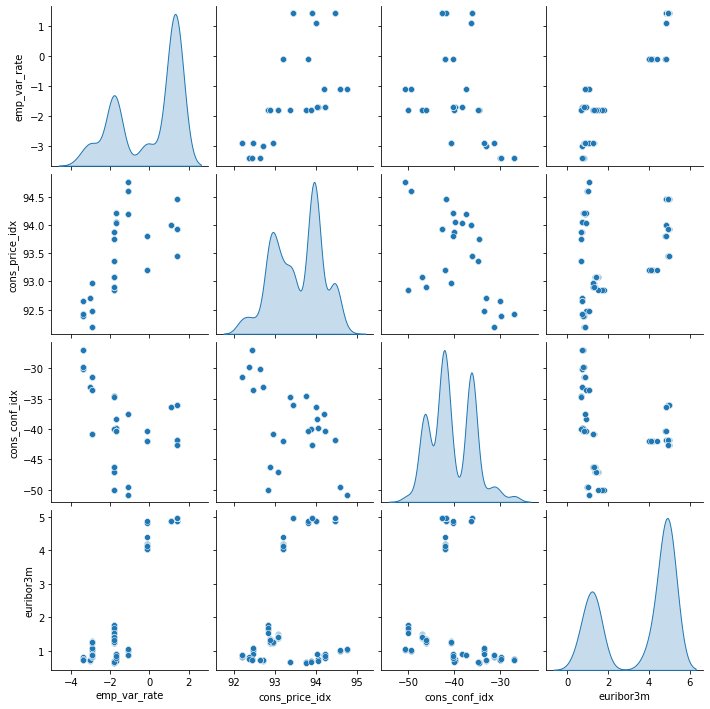

In [9]:
#For demonstration, using only few numerical columns and 1000 random observations
sns.pairplot(x1[['emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m']].sample(1000),diag_kind='kde');

0    0.887936
1    0.112064
Name: y, dtype: float64


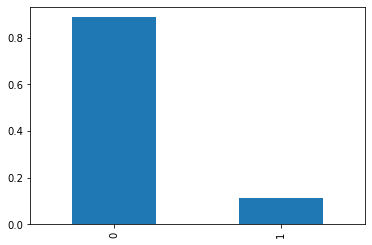

In [10]:
print((y1.value_counts(normalize=True)))
(y1.value_counts(normalize=True)).plot(kind='bar');

In the bar chart above, 1 is 'yes' and 0 is 'no'. As you can see, ~89% customers did not sign up for the term deposit and 11% did. Thus, the target labels are not balanced (i.e not ~50/50%). This will affect the model performance metric we choose. For imbalanced dataset, using `accuracy` as the metric can lead to incorrect results. `ROC-AUC` is often used in such situations. This is a big topic so for now we just need to know that based on the EDA we see that the target is imbalanced and we will have to keep it in mind when building the model.

#### Preprocess the data


In the previous steps we split the data and now we are ready to build the ML pipeline. We build the preprocessing pipeline for catgorical and numerical columns using `Pipeline()` from sklearn.

Categorical columns will be encoded using `OneHotEncoder` and numerical features will be scaled using `StandardScaler`. Standard scaler will bring all numerical features to mean = 0 and std dev = 1. There are various ways of encoding and scaling but for demo purposes we will stick with this. 

Also note that not all ML algorithms need encoding and scaling. Linear methods such as Logistic Regression do while tree-based algorithms (Random Forest, GBMs) don't. We will still preprocess the data so we can use the same pipeline for different algirithms, if needed. 


In [11]:
#Get column index for each of the columns types 

cat_nums = [list(x1.columns).index(col) for col in cat_cols]
num_nums = [list(x1.columns).index(col) for col in num_cols]

In [12]:
print(cat_nums)
print(num_nums)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 13]
[14, 0, 15, 12, 11, 10, 17, 16, 18]


In [13]:
#One hot encode
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False,
                                             handle_unknown='ignore'))
#Build Pipeline
cat_pipe = Pipeline([cat_ohe_step])
num_pipe = Pipeline([('std', StandardScaler())])
transformers = [
    ('cat', cat_pipe, cat_nums),
    ('num', num_pipe, num_nums)
]
ct = ColumnTransformer(transformers=transformers)

ct

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 [1, 2, 3, 4, 5, 6, 7, 8, 9, 13]),
                                ('num',
                                 Pipeline(steps=[('std', StandardScaler())]),
                                 [14, 0, 15, 12, 11, 10, 17, 16, 18])])

Visualize the preprocessing steps:

In [14]:
#Visualize the Preprocessing steps

from sklearn import set_config

set_config(display='diagram')  

ct

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 [1, 2, 3, 4, 5, 6, 7, 8, 9, 13]),
                                ('num',
                                 Pipeline(steps=[('std', StandardScaler())]),
                                 [14, 0, 15, 12, 11, 10, 17, 16, 18])])

#### Build the model

I am going to use **Random forest** algorithm. Random Forest often gives a good baseline performance right out of the box in most scenarios without overfitting. Also, Random Forest has a nice feature - ['Out of Bag' (OOB)](https://en.wikipedia.org/wiki/Out-of-bag_error) score. It will help us estimate model performance over multiple bootstrapped samples thus providing a good proxy for cross-validation performance. I am using OOB here, just to save model building time. In a real project, you will carefully construct a CV scheme.  

We use the above pipeline of transformations with the Random Forest estimator with default parameters. Set the `oob_score=True` to get the OOB score. Also, `class_weight` is set to `balanced` to mitigate class imbalance.


In [15]:
pipe = Pipeline([
        ('ct', ct),
        ('rf', RandomForestClassifier(oob_score=True,
                                      random_state=0, 
                                      class_weight = 'balanced')),
    ])

#Fit the model
pipe.fit(x1,y1)



Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   13]),
                                                 ('num',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler())]),
                                                  [14, 0, 15, 12, 11, 10, 17,
                                                   16, 18])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', oob_score=True,
                                        random_state=0))])

#### Validate the model

In [49]:
#Access the RF estimator from the pipeline
rf = pipe[-1]

# OOB, by default, gives Accuracy score. This is a slightly imbalanced dataset,
# so we will calculate AUC on OOB predictions

oob_pred = np.argmax(rf.oob_decision_function_,axis=1)
auc1 = metrics.roc_auc_score(y1, oob_pred)

print("OOB AUC is: ",np.round(auc1,2))
print("OOB AUC on test set is: ",np.round(roc_auc_score(y2, pipe.predict(x2)),2))



OOB AUC is:  0.63
OOB AUC on test set is:  0.63


Although the AUC is not very high, OOB gave an excellent estimation of the test score. We are happy with the model and it's ready to be used for future predictions.

#### Serialize the Model

Serialize the model using `joblib`

In [50]:
import joblib

joblib.dump(pipe, 'baseline_rf.pkl')

['baseline_rf.pkl']

Test the pickle file on the test set again to make sure it's working as expected.

In [51]:
joblib.load('baseline_rf.pkl').predict(x2)

array([0, 0, 1, ..., 0, 0, 0])

**Success !**

We followed the entire process that's laid out in the 'typical' machine learning process. But is that how it works in real life? 

The answer is - A Resounding **NO**. 

This is in fact just the fraction of the actual process. In reality it's very convoluted, non-linear process with multiple stakeholders/teams involved in creating the final model. You have business stakeholders defining the goals and business objectives, IT/Data Engineers who work on extracting/staging the data, Data scientist creating the models, software engineers integrating it with the product and business intelligence developers consuming the predictions in a dashboard. All these teams collaborate with each other, going through many iterations before finalizng a model.

![ml-ips](https://chapeau.freevariable.com/static/202010/mlops-tube.png)


Ref: https://chapeau.freevariable.com/static/202010/mlops-tube.png

Things that are missing from this 'Typical' process are:
    
   - Multiple stakeholders and collaborators. Identifying business objectives and tying it to model metric
   - Computational resources needed to run the ML models. If you are working on a dataset with millions of rows or a DNN model, you will very likely need GPUs 
   - Experimentation design: algorithms, preprocessing steps, feature selection, feature engineering. You will create 1000s of models before identifying few model candidates that meet the business objectives.
   - Experiment tracking: You will need to efficiently track these 1000s of ML experiments to understand the patterns
   - Data versioning: You will work with several different versions of the data. By the time you arrive at the final model, the data used for training & evaluating that model will be very different from what you started with. You or your colleagues will need to use a different version of that data for som eother project. 
   - Track model artifacts: Each model will have its dependency requirements, input/output schema, hyper parameters
   - Package the model: Containerize the model with the dependendencies 
   - Deploy & monitor: scale, data security, performance monitoring, data drift, model interpretability

This is where **Azure Machine Learning Service** helps! It's a fully managed cloud service that lets you:
 - Work in collaboration while giving control on data security and resources
 - Scale the compute targets as needed
 - Track data and model versions
 - Experiment with thousands of models and keep track of them
 - Deploy the models based on requirements (real-time, batch, IoT) 
 - Monitor in production
 - Trace the model back to data and model artificats
 - DevOps

Azure ML is a **Fully managed MLOPS Platform** that will help you manage the machine learning process based on project requirements.

# Azure ML Service

Hopefully above example gave you reasons to learn and understand why MLOps is important. With Scikit-learn you can create the models *but* it won't help you put those models in production. We will now see how to operationalize this model using Azure ML.     

### Tour of Azure ML Service

Create a free Azure account by visiting the Azure page: https://azure.microsoft.com/en-us/services/machine-learning/
The account is free and you get $200 credit for the first 30 days. Create a 'Pay-As-You-Go' subscription so you will incur costs for only the services you use. Be careful of creating compute resources. Shut them down when you are not using them to avoid a costly surprises. If you are a student, you may get some additional benefits. 

##### Create Pay As You Go subscription

![](https://raw.githubusercontent.com/pawarbi/blog/master/images/azure_sub.JPG)

#### Create Azure ML Resource

[From MS Docs: ](https://docs.microsoft.com/en-us/azure/azure-resource-manager/management/manage-resource-groups-portal#what-is-a-resource-group)A resource group is a container that holds related resources for an Azure solution. The resource group can include all the resources for the solution, or only those resources that you want to manage as a group. You decide how you want to allocate resources to resource groups based on what makes the most sense for your organization. Generally, add resources that share the same lifecycle to the same resource group so you can easily deploy, update, and delete them as a group.

The resource group stores metadata about the resources. Therefore, when you specify a location for the resource group, you are specifying where that metadata is stored. For compliance reasons, you may need to ensure that your data is stored in a particular region.

![amlsub](https://docs.microsoft.com/en-us/azure/includes/media/aml-create-in-portal/create-workspace.gif)

#### What's in Azure Resources ?

![](https://miro.medium.com/max/700/0*2B9p3J0A0efCL2J0.jpg "https://miro.medium.com/max/700/0*2B9p3J0A0efCL2J0.jpg")
Ref: https://miro.medium.com/max/700/0*2B9p3J0A0efCL2J0.jpg

You can access and manage these resources in Azure ML studio using GUI. Some of these resources can also be managed using Azure ML SDK. As you create machine learning models, you will need to access these resources based on project requirements. The Python sdk will allow you to access them in your notebook on the fly. If the resources don't exist, you can create them programmatically.  

###### Architecture
![architecture](https://docs.microsoft.com/en-us/azure/machine-learning/media/concept-azure-machine-learning-architecture/architecture.svg)

### Azure ML Python SDK

I highly recommend creating a virtual enviroment that's specific to Azure ML projects to manage dependencies, especially for Azure Auto ML. Azure AutoML dependencies are often hard to resolve.

![overview](https://docs.microsoft.com/en-us/azure/machine-learning/media/concept-environments/ml-environment.png)

Create a virtual enviroment (e.g `evenv`) and install Azure ML : `pip install --upgrade azureml-sdk[notebooks,automl]`.
You can read more [here](https://docs.microsoft.com/en-us/python/api/overview/azure/ml/install?view=azure-ml-py)

In [52]:
print("I am working with, Azure ML sdk ver: ",azureml.core.VERSION)

I am working with, Azure ML sdk ver:  1.20.0


##### Azure ML Classes

You will use these classes to operationalize the model in Azure ML. This list is defnitely not exchaustive, but 80% of the time you will be working with these classes in Azure ML. I encourage you to read the Microsoft documentation for each of these. 


|Feature  | Description | Class |
|--|--|--|
| Workspace |Foundational resource in the cloud to manage experiments, models  |`Workspace(..)` 
| Compute Instance |Fully managed development environment (DVSM)  |`ComputeInstance(..)`
| Compute Cluster |Fully managed multi-node, scaleable compute  |`ComputeTarget(..)`
| Datastore |Azure Data storage   |`Datastore(..)`
| Dataset |Abstracted File or Tabular data stored in Datastore  |`Dataset(..)`
| Experiment |ML Experiment folder  |`Experiment(..)`
| Run |An instance of an experiment with artifacts   |`Run(..)`
| Log |Log metrics, artifacts related to run   |`Environment(..)`
| Environment |Package environment and dependencies   |`.log(..)`
| ScriptRunConfig |Configuration to run experiments   |`ScriptRunConfig(..)`
|Model |Manage, register, deploy models in the cloud   |`Model(..)`
|Webservice |Containerized packages for deployment, Endpoints   |`Webservice(..)`


### Workspace

You may have different workspaces for different teams, projects etc. In fact, it's recommended to create different resource groups so all the project data, metadata, artifacts remain in that workspace. Especially if you are just trying Azure ML so you can just delete that resource without incurring any charges for any resources in the future. To create or access a workspace, we use `Workspace()` class. The easiest way is to download the `config.json` file from the resource group to your working directory. It has all the tenant, subscription information to connect to that workspace. You will be prompted to authenticate your credentials.

![config](https://docs.microsoft.com/en-us/azure/machine-learning/media/how-to-configure-environment/configure.png)

In [53]:
from azureml.core import Workspace

print("Connecting to the Workspace....", end="",sep='\n')

ws = Workspace.from_config()

print("\nWorkspacename:",ws.name, ", \nWorkspace location:", ws.location)

Connecting to the Workspace....
Workspacename: demows , 
Workspace location: centralus


We are connected to the workspace, now we can access the assets and artifacts in this workspace

### Datastore

When the ML resource was created, Azure automatically created and attached a Blob storage to this workspace. That's the power of managed resources ! You can always attach other Blob, ADLSg2 storage accounts as needed. Let's access this default datastore.

In [54]:
# List all datastores registered in the current workspace
datastores = ws.datastores
for name, datastore in datastores.items():
    print(name, datastore.datastore_type)

workspacefilestore AzureFile
workspaceblobstore AzureBlob


We have two blog storage accounts in this workspace. Let's conenct to the default datastore.

In [55]:
datastore = ws.get_default_datastore()
datastore

{
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-dca32a5a-2be2-43c0-a924-9f9d9b7c7789",
  "account_name": "demows8142312183",
  "protocol": "https",
  "endpoint": "core.windows.net"
}

Remember this is the 'datastore'. We haven't accessed any datasets in this datastore yet. Your data engineering team, for example, can do ETL using ADF, Synapse Analytics, Power Query etc. for you and register a dataset in this datastore.You can also add other datasets to this datastore. We will register the current bank marketing data to this datastore. Once registered, your other team members can access this dataset by just pointing to that dataset.  

### Dataset

Sometimes you may find it easier to use the GUI in the Azure ML studio to register a dataset. The GUI is more interactive and can also generate dataset profile. 

Although it may not seem like a big deal, but being able to register, track, version the datasets seamlessly is one of the most important steps in creating reliable machine lerning models. In the model creation process, you will generate different versions of the data. By versioning and tracking, you will be able to trace which dataset was used for the training the deployed model and thus debug the models in production. 

Don't take my work for it. See what renowned ML researchers, Andrew Ng and Francois Chollet (creator of Tensfor Flow), say about importance of data collection, versioning. [Ref](https://twitter.com/AndrewYNg/status/1353814743190913024)

![data](https://raw.githubusercontent.com/pawarbi/blog/master/images/dataimportance.JPG)

Following DataOps ptactices will pay rich dividends and avoid many headaches when yu have to debug and re-train models in the future.

The dataset you create in Azure ML is actually an abstraction/reference to the stored data and its metadata [(ref)](https://docs.microsoft.com/en-us/azure/machine-learning/concept-data#reference-data-in-storage-with-datasets). The datasets are lazily evaluated, which means:
 - No additional storage cost
 - Data versioning
 - No risk of changing original data
 

##### Register a dataset

In [56]:
from azureml.core import Dataset
from azureml.data.dataset_factory import DataType

#First create a dataset object
ds1 = Dataset.Tabular.from_delimited_files(path=path)

#Register this dataset to the datastore
print("Registering dataset to the cloud...", end="")


ds1 = ds1.register(workspace = ws,
                   name= "bankmarketing",
                   description = "This is the original data")

print("\n\nData registration successful\n\n", Dataset.get_all(ws) )

Registering dataset to the cloud...

Data registration successful

 { 'bankmarketing': DatasetRegistration(id='5845bcb9-fde0-4419-bba8-55b9e8296da8', name='bankmarketing', version=1, description='This is the original data', tags={})}


We have registered the original dataset to the default datastore.

##### Create a new version of the dataset

If you noticed in the training data used above, I dropped the `duration` column.  We will create another version of the same dataset `ds1` by dropping the `duration` column and call it `ds2`.

In [57]:
ds2 = ds1.drop_columns('duration')

ds2 = ds2.register(workspace = ws,
                   name= "bankmarketing",
                   description = "Duration column dropped",
                   create_new_version=True)


In [58]:
Dataset.get_all(ws)

{'bankmarketing': DatasetRegistration(id='9980d47e-df35-45ec-972a-b68a8dd64bf6', name='bankmarketing', version=2, description='Duration column dropped', tags={})}

Note that we still have only 1 dataset in the Datastore. We just replaced the first dataset with the new version. Notice the version number `version=2` above. We can retrieve any version when needed. We have only 1 file in the datastore not 2. This is how, by creating abstraction, we are able to save storage cost. If needed, you can add properties, tags, description to the dataset for future reference. In fact it's a good practice to do so for tracebility.

By default when you reference a dataset, it will always pull the latest version, unless specified.

We are still not done with the dataset. For training, we cleaned the data and split it into train/test. Those also need to be registered to the datastore. We don't have to but that's good DataOps/MLOps practice. Also, anytime you create a cross-validation folds for your final model training/validation, register those in the datastore too for reproducibility. To keep things simple, I am going to upload the train and test data created above to the datastore as one single csv file. Also note that you can directly register a pandas dataframe as a dataset.  

In [59]:
#Create one single file with training and testing data
#Add a column to label which data is train and test
#This way we can keep the data in one single file
# Besure sure to drop the 'data' columns before training and testing.

train = x1.copy()
train['target'] = y1
train['data'] = 'train'

test = x2.copy()
test['target'] = y2
test['data'] = 'test'

train_test_data = train.append(test)



In [60]:
# Register the pandas dataframe as a dataset 
# Add tags for traceability

from azureml.data.dataset_factory import TabularDatasetFactory

ds3 = (TabularDatasetFactory
                .register_pandas_dataframe(
                    train_test_data,
                    target=(datastore,'bank_train_test'),
                    name='bank_train_test',
                    tags = {'Author':'Sandeep','Project':'Bank Marketing'},
                    show_progress=True)
        )

Method register_pandas_dataframe: This is an experimental method, and may change at any time.<br/>For more information, see https://aka.ms/azuremlexperimental.


Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to bank_train_test/e9360b10-63b9-4d6b-be50-53add1436e99/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


In [61]:
for dataset in Dataset.get_all(ws):
    print(dataset)

bank_train_test
bankmarketing


Just for illustration purposes, if we want to retrieve a dataset by name, we can use the `get_by_name()` method. We can also see the `id` (i.e unique id) for the dataset. We will log this as an artifact during model building so we can trace the exact train/test used for future reference.

In [62]:
Dataset.get_by_name(ws, 'bank_train_test')

{
  "source": [
    "('workspaceblobstore', 'bank_train_test/e9360b10-63b9-4d6b-be50-53add1436e99/')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ReadParquetFile",
    "DropColumns"
  ],
  "registration": {
    "id": "7b81a6c0-1e72-4948-86bb-ddac0e4e5d77",
    "name": "bank_train_test",
    "version": 1,
    "tags": {
      "Author": "Sandeep",
      "Project": "Bank Marketing"
    },
    "workspace": "Workspace.create(name='demows', subscription_id='4cedc5dd-e3ad-468d-bf66-32e31bdb9148', resource_group='1-f4dcfa62-playground-sandbox')"
  }
}

In [64]:
ds_uid = '7b81a6c0-1e72-4948-86bb-ddac0e4e5d77'

Datastore has two datasets now which can be accessed anytime or versioned.

### Compute 

We can train the model locally and deploy it to the cloud. But if you want to scale-up the process by parallelizing model training, you can use the compute cluster. There two types of compute:

 - Compute Instance: This is like a managed VM with R,Python, Jupyter installed. You can use it for remote training but can also be accessed from the Studio for development. 
 
 - Compute Cluster: This is a scalable multi-node compute, meaning if your training requires lot of compute power (e.g. 12 machines with 24 cores each) you can push the training to the compute cluster to do that. This can also be used for batch-inferencing.
 
For example purposes, I will show how to create it but won't use it. Compute is expensive. Companies often create compute quota to limit cost and use remote compute for hyperparameter tuning or large jobs. Note that if you are using Azure ML  pipelines, you have to use Compute instance/cluster and local training is not available.

I generally prefer creating compute using GUI because you can see the cost of each compute option. 

In [65]:
from azureml.core.compute import ComputeTarget, AmlCompute


compute_name = "DS12V2"

try:
    vm = ComputeTarget(ws, compute_name)
    print(f"{compute_name} exists already")
except:
    compute_config = AmlCompute.provisioning_configuration(vm_size="Standard_D2_V2", max_nodes=4)
    vm = ComputeTarget.create(ws, compute_name, compute_config)
    
vm.wait_for_completion(show_output=True)

DS12V2 exists already

Running


### Experiment

This is the heart of machine learning and where all the magic happens. When you are working on a machine learning project, it's rarely a linear process as we discussed above. You try many different algorithms, debug them, understand how they work, try different preprocessing steps, feature engineering, data augmentation etc,, which means you will end up creating thousands of models per project. To keep track of all these experimental runs, Azure ML provides the `Experiment` class. 

Think of `Experiment()` as a big giant folder where you save the model runs and the artifacts associated with that experiment. At the end of your experiment, you will see how each model performed based on selected metric and choose the right model for your project. The steps you will follow for each experimental run:

 - Create Experiment object
 - Start run
 - Log metrics
 - Get run/experiment details
 
Just for demonstration purposes, I will create a `Demo Experiment` and log values `1,2,3` for metric called `demo_metric`. 

In [66]:
from azureml.core import Experiment

exp1 = Experiment(workspace=ws, name="Demo_Experiment")

exp1

Name,Workspace,Report Page,Docs Page
Demo_Experiment,demows,Link to Azure Machine Learning studio,Link to Documentation


If you click on the above link, it will take you directly to the Azure ML Studio Experiment page. We will created the Experiment, i.e folder. Now, we *run* some experiments

In [67]:
#Start run
from azureml.widgets import RunDetails


demo_run = exp1.start_logging()

#Start Logging
demo_run.log('demo_metric' , 1)
demo_run.log('demo_metric' , 2)
demo_run.log('demo_metric' , 3)

#Stop logging

demo_run.complete()

RunDetails(demo_run).show()


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Remember to use `run.complete()` to stop the run. A better and easier way is to use `with` as follows. When the run is complete, it will be completed automatically.

For the bank marketing project, we created a random forest model using default hyper params. To demonstrate how create experiments, we will train four RF models by changing the `max_depth` parameter. When `max_depth` is None, it's just a stump of a tree. As we grow the depth, features are split and will identify non-linear patterns in the data. We will try `max_depth` = [None, 5,7,9]. In a real project, you will perform hyperparameter optimization using RandomSearch, Baysian Optimization using SKLearn, HyperOpt, HyperDrive etc. 


In [68]:
#Create another experiment called bank
from azureml.core import Run 

#Define new experiment
bank = Experiment(workspace=ws, name="Bank_Marketing", )

#Define Hyperparameter to tune
max_depth=[None,5,7,9] 
    
#Run the experiment

for depth in max_depth:
    
    with bank.start_logging() as run: #snapshot only the snapshot directory snapshot_directory = 'snapshot'

        #Log max_depth
        run.log('Model', 'Random Forest')
        run.log('Dataset', ds_uid)
        run.log('max_depth', int(0 if depth is None else depth))
        run.log_list("input_columns", list(x1.columns))
        
        #train the pipeline
        pipe2 = Pipeline([
            ('ct', ct),
            ('rf', RandomForestClassifier(oob_score=True,
                                          random_state=0, 
                                          class_weight = 'balanced', 
                                          max_depth = depth )),
        ])

        pipe2.fit(x1,y1)
        

        rf2 = pipe2[-1]

        #Log model details
        run.log('oob_score', 'True')
        run.log('class_weight', 'balanced')


        oob_pred2 = np.argmax(rf2.oob_decision_function_,axis=1)
        auc2 = metrics.roc_auc_score(y1, oob_pred2)
                         
        #Log metrics
        run.log('oob_auc', auc2)
        
        print("max_depth: ",depth,"   , oob_auc: ", np.round(auc2,3))
        
RunDetails(run).show()


max_depth:  None    , oob_auc:  0.626
max_depth:  5    , oob_auc:  0.74
max_depth:  7    , oob_auc:  0.746
max_depth:  9    , oob_auc:  0.746


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

By increasing the max_depth, AUC increased from 62% to 74% ! 

In the experiment above, we logged the model class, dataset used, hyper parameter, input columns, AUC score etc. After the experiment is complete, you can visit the Studio to see the output and/or interact with the model artifacts. 

Note that by default, when you create an experiment, Azure ML will take a snapshot of the working folder. See below. Depending on your needs this is a good/bad thing. You may not want to snapshot all the files and folder. You can specify an `amlingnore` or `gitignore` file to indicate which files/folders to ignore. Another option is to specify which directory to snapshot. For example, above I specified `start_logging(snapshot_directory = 'snapshot')` to snapshot the `snapshot` folder. This helps reproducibility. You can save data, yaml, config files etc so you or your colleagues can reproduce the results months later. The maximum snapshot limit is 300MB. If your directory exceeds that the run will fail. You can increase the limit but you will incur storage costs. Also, directories `./output` and `./logs` are special. They will always be automatically uploaded as snapshot.

I recommending 'snapshotting' only the required model artifacts and specifying which folder to snapshot.



![](https://raw.githubusercontent.com/pawarbi/blog/master/images/snapshot.JPG)

### Model Packaging - (Registration & Deployment)

We ran some experiments with `max_depth` hyperparameters and found that using `max_depth` = [5,7,9] will improve the results significantly. Let's use 'one-standard error' rule [(Ref: ESL, pp61)](https://web.stanford.edu/~hastie/ElemStatLearn//printings/ESLII_print12_toc.pdf) to pick a parsomonious model. We will pick `max_depth=5` for create a pickle file and deploy it in service.

Model accuracy is not the only metric, in fact it shouldn't be, to select a model. Focus should be on selecting simple, parsimonious models that are interpretable & explainable. Watch my interpretability presentation for more details. For now, we will assume this is the right model for us. 

In [69]:
final_model = Pipeline([
        ('ct', ct),
        ('rf', RandomForestClassifier(oob_score=True,
                                      random_state=0, 
                                      class_weight = 'balanced',
                                      max_depth = 5)),
        ])
final_model.fit(x1,y1)

joblib.dump(final_model, 'bank_model.pkl')

['bank_model.pkl']

In [70]:
test_final_model = joblib.load('bank_model.pkl')

In [71]:
test_final_model.predict(x1.iloc[0:])

array([0, 0, 0, ..., 1, 1, 1])

In [79]:
print("AUC on Test set: ,", np.round(metrics.roc_auc_score(y2, test_final_model.predict(x2)),2))

AUC on Test set: , 0.74


Excellent, OOB score is same as the test (very rare!).

There are actually multiple ways to register and deploy a model as webservice. Typically, you will first create training script, register an environment, create inference schema, register model, create deployment config etc. But there is a shorter way to do all of that in one single step. Usually you will go through everything step-by-step but for demonstration purposes, I will roll these steps into one by using `ResourceConfiguration` class. Also, note that this is for real-time inferencing using Azure Container Instance. You should always deploy the model locally first for debugging, testing before deploying it to the cloud. For batch-inferencing, follow [these steps](https://docs.microsoft.com/en-us/learn/modules/deploy-batch-inference-pipelines-with-azure-machine-learning/). 

You can also register and deploy using the interface in the Studio.

We will also save the sample features and labels for future reference and model debugging. 

In [81]:
np.savetxt('features.csv', np.array(x1), delimiter=',',  fmt='%s')
np.savetxt('labels.csv', y1, delimiter=',')

In [82]:

datastore.upload_files(files=['./features.csv', './labels.csv'],
                       target_path='sample_data/',
                       overwrite=True)

input_dataset = Dataset.Tabular.from_delimited_files(path=[(datastore, 'sample_data/features.csv')])
output_dataset = Dataset.Tabular.from_delimited_files(path=[(datastore, 'sample_data/labels.csv')])

Uploading an estimated of 2 files
Uploading ./features.csv
Uploaded ./features.csv, 1 files out of an estimated total of 2
Uploading ./labels.csv
Uploaded ./labels.csv, 2 files out of an estimated total of 2
Uploaded 2 files


In [83]:
from azureml.core import Model
from azureml.core.resource_configuration import ResourceConfiguration

model = (Model.register(workspace = ws, 
                      model_name = "bank_model",                    #name for the model
                      model_path = './bank_model.pkl',              #Specify the .pkl file
                      model_framework=Model.Framework.SCIKITLEARN,  #This will automatically create environment & schema
                      sample_input_dataset=input_dataset,           #Sample input
                      sample_output_dataset=output_dataset,         #Sample output  
                      resource_configuration=ResourceConfiguration(cpu=1, memory_in_gb=0.5), #ACI config to use
                      description='Bank Marketing model to predict of customer will sign up',
                      tags = {'Author':'Sandeep', 
                              'Date':'2/18/2021', 
                              'Model':'RandomForest', 
                              'Dataset':ds_uid} 
                      ))

Registering model bank_model


In [84]:
print('Name:', model.name)
print('Version:', model.version)

Name: bank_model
Version: 1


In [85]:
service = Model.deploy(ws, "service3", [model])
service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running............................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [86]:
service

AciWebservice(workspace=Workspace.create(name='demows', subscription_id='4cedc5dd-e3ad-468d-bf66-32e31bdb9148', resource_group='1-f4dcfa62-playground-sandbox'), name=service3, image_id=None, compute_type=None, state=ACI, scoring_uri=Healthy, tags=http://ec1b6ac7-1a4a-4d2e-8f98-ed8f8628ba44.centralus.azurecontainer.io/score, properties={}, created_by={'hasInferenceSchema': 'True', 'hasHttps': 'False'})

In [87]:
service.state

'Healthy'

Webservcie status is `Healthy` and ready to be used in production for inferencing.

#### Create an input data to test inferencing

We will send 10 sample observations to test if the service is responding and returning expected output. You can also test this using the scoring_uri.

In [89]:
import json 

input = json.dumps({'data':x1.iloc[:10,:].to_dict('list'),'method': 'predict'})
headers = {'Content-Type': 'application/json'}

In [90]:
output = service.run(input)

In [91]:
output

{'predict': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]}

We got the response back with predictions. Service is running and ready for action.
If you are trying this example, be sure to delet the service and the weorkspace to avoid charges.

In [87]:

service.delete()

#### Monitor the Webservice

To monitor the performance of the webservice and the deployed model, we need to do few things:

   - Stress test the model for distribution shifts and loads
   - Collect webservice performance metric using **Application Insights**. This will help us collect:
       - Responses
       - Request rates, response time, failure rates
       - Exceptions
   
   - Monitor **Concept Drift**
       - Performance of the ML model will likely degrade over time due to change in distribution of the input data
       - By monitoring drift, we can measure the drift and decide when to re-train the model 
       
   - Collect **Model Interpretability** data during inferencing
       - This is to track how model is creating predictions and if predictions are fair 
       
       
This is big topic and will require a separate presentation. But just know that with Azure ML service, you can monitor the model performance in production environment.

### Next Steps

This was just the introduction to give you flavor for how to use Azure ML sdk. There are more advanced methods available depending on the project needs. I would encourage you to research those on your own from MS Docs and MS Learn.

 - Azure ML Pipelines
 - Azure ML HyperDrive
 - Azure Auto ML
 - Azure ML Studio Designer

### Resources

 - [Microsoft Learn](https://docs.microsoft.com/en-us/learn/paths/create-machine-learn-models/)
 - [Microsoft Documentation](https://docs.microsoft.com/en-us/python/api/overview/azure/ml/?view=azure-ml-py)


Thank you ! I hope you found this helpful. As always, feel free to get in touch if you have any questions. 